### Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%bash
wget https://raw.githubusercontent.com/Qsinap/Breast-cancer-segmentation/main/Codes/MultiResUNet.py
wget https://raw.githubusercontent.com/Qsinap/Breast-cancer-segmentation/main/Codes/functions_seg.py
pip install keras==2.3.1
pip install tensorflow==2.2.0
pip install keras_applications==1.0.8
pip install image-classifiers==1.0.0
pip install efficientnet==1.0.0
pip install keras-unet
pip install tf-semantic-segmentation
pip install segmentation-models

In [ ]:
%env SM_FRAMEWORK=tf.keras

In [ ]:
import functions_seg as fs
import pandas as pd
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import tensorflow as tf
from sklearn.utils.extmath import cartesian

### Functions

In [ ]:
resized_height = 256  
resized_width  = 256
max_dist = math.sqrt(resized_height**2 + resized_width**2)
n_pixels = resized_height * resized_width
all_img_locations = tf.convert_to_tensor(cartesian([np.arange(resized_height), np.arange(resized_width)]), tf.float32)

In [ ]:
def tf_repeat(tensor, repeats):
    with tf.compat.v1.variable_scope("repeat"):
        expanded_tensor = tf.expand_dims(tensor, -1)
        multiples = [1] + repeats
        tiled_tensor = tf.tile(expanded_tensor, multiples = multiples)
        repeated_tesnor = tf.reshape(tiled_tensor, tf.shape(tensor) * repeats)
    return repeated_tesnor

In [ ]:
def Weighted_Hausdorff_loss(y_true, y_pred):

    terms_1 = []
    terms_2 = []
    y_true = tf.squeeze(y_true, axis=-1)
    y_pred = tf.squeeze(y_pred, axis=-1)

    for b in range(batch_size):
        gt_b = y_true[b]
        prob_map_b = y_pred[b]
        
        n_gt_pts = tf.reduce_sum(gt_b)
        gt_b = tf.where(tf.cast(gt_b, tf.bool))
        gt_b = tf.cast(gt_b, tf.float32)
        d_matrix = tf.sqrt(tf.maximum(tf.reshape(tf.reduce_sum(gt_b*gt_b, axis=1), (-1, 1)) + tf.reduce_sum(all_img_locations*all_img_locations, axis=1)-2*(tf.matmul(gt_b, tf.transpose(all_img_locations))), 0.0))
        d_matrix = tf.transpose(d_matrix)

        p = tf.reshape(prob_map_b, (n_pixels, 1))
        n_est_pts = tf.reduce_sum(p)
        p_replicated = tf_repeat(tf.reshape(p, (-1, 1)), [1, n_gt_pts])
        eps = 1e-6
        alpha = 4

        term_1 = (1 / (n_est_pts + eps)) * tf.reduce_sum(p * tf.reshape(tf.reduce_min(d_matrix, axis=1), (-1, 1)))
        d_div_p = tf.reduce_min((d_matrix + eps) / (p_replicated**alpha + eps / max_dist), axis=0)
        d_div_p = tf.clip_by_value(d_div_p, 0, max_dist)
        term_2 = tf.reduce_mean(d_div_p, axis=0)
        terms_1.append(term_1)
        terms_2.append(term_2)
    terms_1 = tf.stack(terms_1)
    terms_2 = tf.stack(terms_2)
    terms_1 = tf.compat.v1.Print(tf.reduce_mean(terms_1), [tf.reduce_mean(terms_1)], "term 1")
    terms_2 = tf.compat.v1.Print(tf.reduce_mean(terms_2), [tf.reduce_mean(terms_2)], "term 2")
    res = terms_1 + terms_2
    return res

In [ ]:
losses={'binary_crossentropy': 'binary_crossentropy', 'dice_coef_loss': fs.dice_coef_loss, 'weighted_cross_entropyloss': fs.weighted_cross_entropyloss, 'tversky_loss': fs.tversky_loss, 'log_cosh_dice_loss': fs.log_cosh_dice_loss, 'Weighted_Hausdorff': Weighted_Hausdorff_loss}
n_losses=['Weighted_Hausdorff', 'binary_crossentropy', 'dice_coef_loss', 'weighted_cross_entropyloss', 'tversky_loss', 'log_cosh_dice_loss']

In [ ]:
backbones=['None', 'efficientnetb7', 'senet154', 'seresnet152', 'seresnext101', 'inceptionresnetv2', 'mobilenetv2', 'densenet201', 'resnet152', 'resnext101', 'vgg19']

### [Datos](https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM)


In [ ]:
path='/content/drive/MyDrive/INDIGO_MLR/CancerDeMama/'

In [ ]:
df = pd.DataFrame(columns=('tumor_type','run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time','augm', 'jaccard_distances', 'acc','sensitivity','specificity','FPR','dice_coef', 'result_mat'))
df.head()

,tumor_type,run_n,network,optimizer,loss,epochs,total_parameters,time,augm,jaccard_distances,acc,sensitivity,specificity,FPR,dice_coef,result_mat


In [ ]:
datos=sio.loadmat(path+'/data.mat')
images=datos['images'].astype('float32')
masks=(datos['masks']!=0).astype('float32')
n_ima,row,cols=np.shape(images)
images=images.reshape((*images.shape,1))
masks=masks.reshape((*masks.shape,1))
del datos

In [ ]:
imagesRGB=np.zeros((n_ima, row, cols, 3))
imagesRGB[...,0]=imagesRGB[...,1]=imagesRGB[...,2]=images[...,0]
images=imagesRGB
del imagesRGB

In [ ]:
sp,sp2 = int(n_ima*0.8), int(n_ima*0.7)
x_test, x_train, x_val=images[sp:], images[:sp2], images[sp2:sp]
y_test, y_train, y_val=masks[sp:], masks[:sp2], masks[sp2:sp]
print(np.shape(x_test), np.shape(x_train), np.shape(x_val))
del images, masks

(143, 256, 256, 3) (499, 256, 256, 3) (72, 256, 256, 3)


### Data augmentation

In [ ]:
x_train=np.concatenate((x_train, np.flip(x_train, 2)), axis=0)
x_train=np.concatenate((x_train, np.rot90(x_train,1,axes=(1,2)),np.rot90(x_train,2,axes=(1,2)),np.rot90(x_train,3,axes=(1,2))), axis=0)
y_train=np.concatenate((y_train, np.flip(y_train, 2)), axis=0)
y_train=np.concatenate((y_train, np.rot90(y_train,1,axes=(1,2)),np.rot90(y_train,2,axes=(1,2)),np.rot90(y_train,3,axes=(1,2))), axis=0)

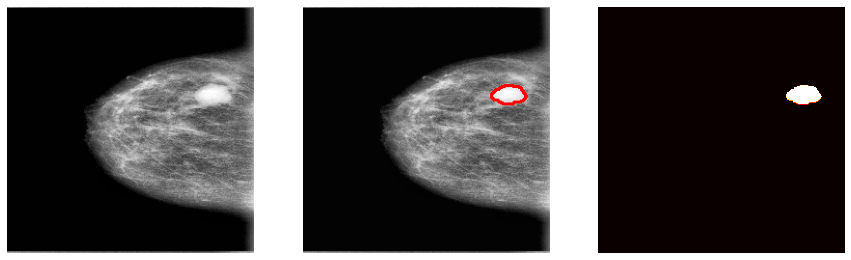

In [ ]:
ind=np.random.choice(n_ima)
fs.plot_mamo(x_train[ind][...,0], y_train[ind][...,0])

### Training

In [ ]:
paths=path+'weights/'

In [ ]:
if os.path.exists(paths):
  print('done')
else:
  os.system('mkdir '+paths)

done


In [ ]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping
from IPython.display import clear_output

In [ ]:
red='unet'

tumor_t=''
epochs=150
optimizer='Adam'
augmentation='8'
batch_size=4

for back_b in backbones:
  network=red+'_'+back_b

  name='_'.join(['breast_cancer_'+str(tumor_t),network,optimizer])

  if not os.path.exists(path+name+'.csv'):
    df.to_csv(path+name+'.csv')

  for i in range(18,19):
    for j in n_losses:
      error=False
      tic = time.time()
      name_m='_'.join([name,j,'run',str(i)])  
      print(name_m)

      try:
        del model
      except:
        print('done')

      model=fs.read_model(red,back_b)
      model.compile(optimizer=optimizer, loss=losses[j], metrics=['acc', fs.jaccard_distance, fs.dice_coef])
      ES = EarlyStopping(patience=10, min_delta=0.00001, restore_best_weights=True)
      MCP = ModelCheckpoint(filepath=path+name_m+'_w.hdf5', save_best_only=True, save_weights_only=True)
      toc=time.time()-tic

      try:
        results = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=4, epochs=epochs)
        model.save_weights(paths+name_m+"w.h5")
      except:
        print('Training error')
        error=True
      
      if not error:
        sio.savemat(paths+name_m+'_r.mat', results.history)

        #validation
        fs.validation_modela_and_save(path+name+'.csv',i,j,name_m+'_r.mat')
        clear_output(wait=True)

breast_cancer__unet_efficientnetb7_Adam_Weighted_Hausdorff_run_18
done
258441216/258434480 [==============================] - 4s 0us/step
Epoch 1/150
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:

998/998 [==============================] - 339s 339ms/step - loss: 45.0893 - acc: 0.9136 - jaccard_distance: 0.0992 - dice_coef: 0.0874 - val_loss: 30.2168 - val_acc: 0.9439 - val_jaccard_distance: 0.0596 - val_dice_coef: 0.1226
Epoch 2/150
998/998 [==============================] - 333s 333ms/step - loss: 37.4679 - acc: 0.9576 - jaccard_distance: 0.0466 - dice_coef: 0.1172 - val_loss: 24.3731 - val_acc: 0.9592 - val_jaccard_di